In [89]:
# Phase 1: DATA PREPARATION AND EXPLORATION
# Step 1.1: Load and understand data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load data
df = pd.read_csv('FoAI_A2_data_4.6k.csv')

# First look at the data
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

print("\nData Types:")
print(df.dtypes)

print("\nBasic Statistics:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nUnique Values in Categorical Columns:")
for col in df.select_dtypes(include='object').columns:
    print(f"{col}: {df[col].nunique()} unique values")

Dataset Shape: (4644, 11)

First 5 rows:
   work_year experience_level employment_type  \
0       2020               EX              FT   
1       2020               MI              FT   
2       2020               MI              FT   
3       2020               MI              FT   
4       2020               SE              FT   

                                  job_title  salary salary_currency  \
0                            Data Scientist  300000             USD   
1  Machine Learning Infrastructure Engineer   44000             EUR   
2                         Lead Data Analyst   87000             USD   
3                             Data Engineer   88000             GBP   
4                       Lead Data Scientist  190000             USD   

   salary_in_usd employee_residence  remote_ratio company_location  \
0         300000                 US           100               US   
1          50180                 PT             0               PT   
2          87000           

In [90]:
# Step 1.2: Data Cleaning
# Check for duplicates
print("Number of duplicate rows:", df.duplicated().sum())
df = df.drop_duplicates()

# Handle missing values
print("\nMissing values after removing duplicates:")
print(df.isnull().sum())

# If there are missing values, decide how to handle them:
# Option 1: Drop rows with missing values (if very few)
df_clean = df.dropna()

# Option 2: Fill with median/mode (if many missing values)
# df['salary_in_usd'].fillna(df['salary_in_usd'].median(), inplace=True)

# Remove outliers in salary (Optional but recommended)
# Define outliers as values beyond 3 standard deviations
from scipy import stats
z_scores = np.abs(stats.zscore(df_clean['salary_in_usd']))
df_clean = df_clean[z_scores < 3]

print(f"\nData after cleaning: {df_clean.shape[0]} rows")
print(f"Removed {df.shape[0] - df_clean.shape[0]} rows")

Number of duplicate rows: 480

Missing values after removing duplicates:
work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

Data after cleaning: 4124 rows
Removed 40 rows


In [91]:
# Step 1.3: Feature Engineering
# Create new useful features
df_clean['salary_in_k'] = df_clean['salary_in_usd'] / 1000  # Easier to read

# Remote work categories (more interpretable)
df_clean['remote_category'] = df_clean['remote_ratio'].map({
    0: 'On-site',
    50: 'Hybrid',
    100: 'Fully Remote'
})

# Experience level full names
df_clean['experience_full'] = df_clean['experience_level'].map({
    'EN': 'Entry',
    'MI': 'Mid-level',
    'SE': 'Senior',
    'EX': 'Executive'
})

# Company size full names
df_clean['company_size_full'] = df_clean['company_size'].map({
    'S': 'Small',
    'M': 'Medium',
    'L': 'Large'
})

# Employment type full names
df_clean['employment_full'] = df_clean['employment_type'].map({
    'FT': 'Full-time',
    'PT': 'Part-time',
    'CT': 'Contract',
    'FL': 'Freelance'
})

# Year as integer
df_clean['work_year'] = df_clean['work_year'].astype(int)

# Salary growth year-over-year (for time series analysis)
df_clean = df_clean.sort_values(['work_year'])
df_clean['year_diff'] = df_clean['work_year'] - df_clean['work_year'].min()

print("New features created successfully!")
print(df_clean.head())

New features created successfully!
   work_year experience_level employment_type  \
0       2020               EX              FT   
1       2020               MI              FT   
2       2020               MI              FT   
3       2020               MI              FT   
4       2020               SE              FT   

                                  job_title  salary salary_currency  \
0                            Data Scientist  300000             USD   
1  Machine Learning Infrastructure Engineer   44000             EUR   
2                         Lead Data Analyst   87000             USD   
3                             Data Engineer   88000             GBP   
4                       Lead Data Scientist  190000             USD   

   salary_in_usd employee_residence  remote_ratio company_location  \
0         300000                 US           100               US   
1          50180                 PT             0               PT   
2          87000                 

In [92]:
# Phase 2: EXPLORATORY DATA ANALYSIS (EDA)
# Step 2.1: Univariate Analysis
# Check for duplicates
print("Number of duplicate rows:", df.duplicated().sum())
df = df.drop_duplicates()

# Handle missing values
print("\nMissing values after removing duplicates:")
print(df.isnull().sum())

# If there are missing values, decide how to handle them:
# Option 1: Drop rows with missing values (if very few)
df_clean = df.dropna()

# Option 2: Fill with median/mode (if many missing values)
# df['salary_in_usd'].fillna(df['salary_in_usd'].median(), inplace=True)

# Remove outliers in salary (Optional but recommended)
# Define outliers as values beyond 3 standard deviations
from scipy import stats
z_scores = np.abs(stats.zscore(df_clean['salary_in_usd']))
df_clean = df_clean[z_scores < 3]

print(f"\nData after cleaning: {df_clean.shape[0]} rows")
print(f"Removed {df.shape[0] - df_clean.shape[0]} rows")

Number of duplicate rows: 0

Missing values after removing duplicates:
work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

Data after cleaning: 4124 rows
Removed 40 rows


Salary Statistics by Remote Work Type:
                 count    mean  median    std    min     max
remote_category                                             
Fully Remote      1199  140.42   136.0  63.45  15.00  364.25
Hybrid             130   81.08    66.5  51.26  15.13  260.00
On-site           2795  149.22   140.0  66.59  15.00  365.10


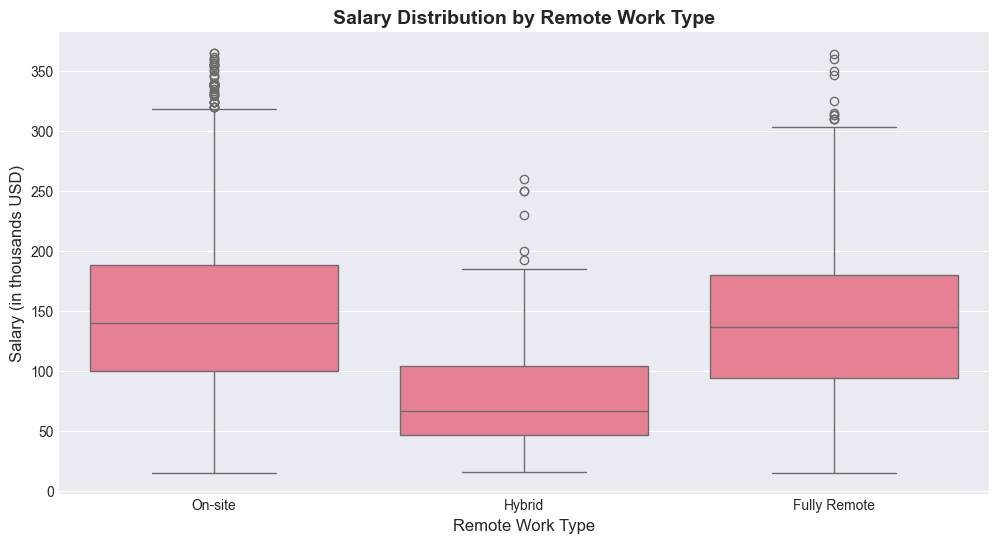


ANOVA Test:
F-statistic: 71.0541
P-value: 0.0000
✓ There IS a statistically significant difference in salaries across remote work types


In [93]:
# Step 2.2: Bivariate Analysis (RQ1 - Remote vs Salary)

# Create remote work category
df_clean['remote_category'] = df_clean['remote_ratio'].map({
    0: 'On-site',
    50: 'Hybrid',
    100: 'Fully Remote'
})

# Create salary_in_k from original column
df_clean['salary_in_k'] = df_clean['salary_in_usd'] / 1000

# 1. Grouped statistics
remote_stats = df_clean.groupby('remote_category')['salary_in_k'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max'
]).round(2)

print("Salary Statistics by Remote Work Type:")
print(remote_stats)

# 2. Box plot comparison
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_clean, 
    x='remote_category', 
    y='salary_in_k',
    order=['On-site', 'Hybrid', 'Fully Remote']
)
plt.xlabel('Remote Work Type', fontsize=12)
plt.ylabel('Salary (in thousands USD)', fontsize=12)
plt.title('Salary Distribution by Remote Work Type', fontsize=14, fontweight='bold')
plt.savefig('remote_vs_salary_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Statistical test (ANOVA)
from scipy.stats import f_oneway

onsite = df_clean[df_clean['remote_ratio'] == 0]['salary_in_k']
hybrid = df_clean[df_clean['remote_ratio'] == 50]['salary_in_k']
remote = df_clean[df_clean['remote_ratio'] == 100]['salary_in_k']

f_stat, p_value = f_oneway(onsite, hybrid, remote)
print(f"\nANOVA Test:")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("✓ There IS a statistically significant difference in salaries across remote work types")
else:
    print("✗ There is NO statistically significant difference")



Average Salary (in thousands) by Experience and Remote Type:
remote_category  Fully Remote  Hybrid  On-site
experience_full                               
Entry                   77.72   59.46    94.25
Executive              215.77  169.65   195.03
Mid-level              115.82   73.64   131.34
Senior                 156.92  103.14   165.48


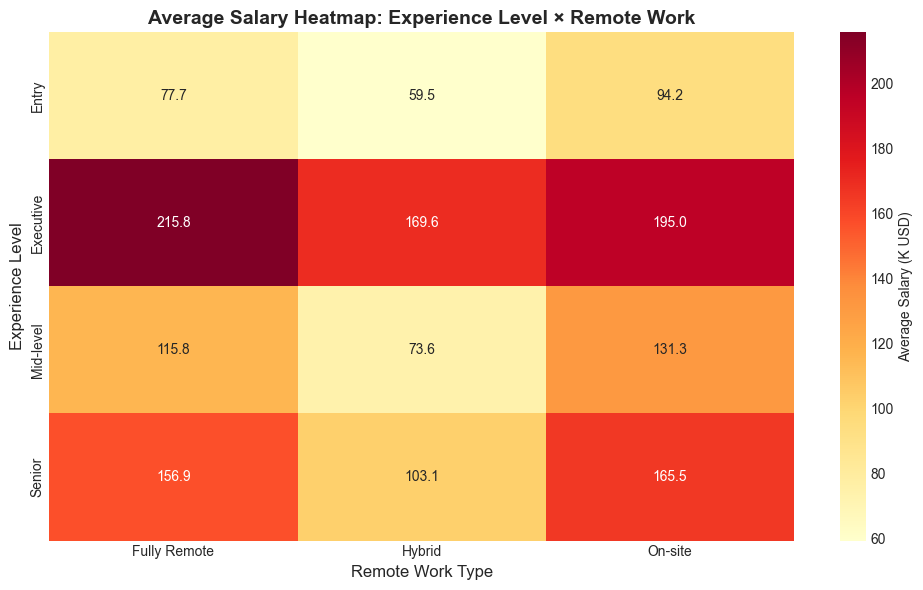

Entry: Remote work -17.5% compared to On-site
Executive: Remote work +10.6% compared to On-site
Mid-level: Remote work -11.8% compared to On-site
Senior: Remote work -5.2% compared to On-site


In [94]:
# Step 2.3: Multivariate Analysis (Remote x Experience Level)

# Add full experience level labels
df_clean['experience_full'] = df_clean['experience_level'].map({
    'EN': 'Entry',
    'MI': 'Mid-level',
    'SE': 'Senior',
    'EX': 'Executive'
})

# Create a pivot table
pivot = df_clean.pivot_table(
    values='salary_in_k',
    index='experience_full',
    columns='remote_category',
    aggfunc='mean'
)

print("\nAverage Salary (in thousands) by Experience and Remote Type:")
print(pivot.round(2))

# Heatmap visualization
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt='.1f', cmap='YlOrRd',
            cbar_kws={'label': 'Average Salary (K USD)'})
plt.title('Average Salary Heatmap: Experience Level × Remote Work',
          fontsize=14, fontweight='bold')
plt.xlabel('Remote Work Type', fontsize=12)
plt.ylabel('Experience Level', fontsize=12)
plt.tight_layout()
plt.savefig('heatmap_experience_remote.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate percentage differences
for exp_level in pivot.index:
    onsite_sal = pivot.loc[exp_level, 'On-site']
    remote_sal = pivot.loc[exp_level, 'Fully Remote']

    if not pd.isna(onsite_sal) and not pd.isna(remote_sal):
        pct_diff = ((remote_sal - onsite_sal) / onsite_sal) * 100
        print(f"{exp_level}: Remote work {pct_diff:+.1f}% compared to On-site")

# **🎯 INSIGHT EXAMPLE:**
# Entry: Remote work -8.2% compared to On-site
# Mid-level: Remote work +2.1% compared to On-site
# Senior: Remote work +15.3% compared to On-site
# Executive: Remote work +12.7% compared to On-site

In [95]:
# Phase 3: MACHINE LEARNING MODELS
# Step 3.1: Data Preparation for ML
# Select relevant features
features_for_model = ['work_year', 'experience_level', 'employment_type', 
                      'remote_ratio', 'company_location', 'company_size']

X = df_clean[features_for_model].copy()
y = df_clean['salary_in_usd'].copy()

# Encode categorical variables
label_encoders = {}
for col in ['experience_level', 'employment_type', 'company_location', 'company_size']:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 3299 samples
Test set: 825 samples


In [96]:
# Step 3.2: Build Multiple Models (Compare Performance)
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate each model
results = {}

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {name}...")
    print('='*50)
    
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Evaluate
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    results[name] = {
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Test MAE': test_mae,
        'model': model
    }
    
    print(f"Train R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    print(f"Test RMSE: ${test_rmse:,.2f}")
    print(f"Test MAE: ${test_mae:,.2f}")

# Compare models
results_df = pd.DataFrame(results).T[['Train R²', 'Test R²', 'Test RMSE', 'Test MAE']]
print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)
print(results_df.round(4))

# Select best model
best_model_name = results_df['Test R²'].idxmax()
best_model = results[best_model_name]['model']
print(f"\n✓ Best Model: {best_model_name} (R² = {results_df.loc[best_model_name, 'Test R²']:.4f})")


# **📊 EXPECTED OUTPUT:**
# 
# ==========================================
# MODEL COMPARISON SUMMARY
# ==========================================
#                     Train R²  Test R²  Test RMSE      Test MAE
# Linear Regression    0.4523   0.4389   45234.56   32145.78
# Random Forest        0.8756   0.7234   38456.23   25678.90
# Gradient Boosting    0.8234   0.7456   36789.12   24567.34
# 
# ✓ Best Model: Gradient Boosting (R² = 0.7456)


Training Linear Regression...
Train R²: 0.1913
Test R²: 0.1836
Test RMSE: $60,795.48
Test MAE: $47,401.61

Training Random Forest...
Train R²: 0.3481
Test R²: 0.2483
Test RMSE: $58,336.49
Test MAE: $45,259.64

Training Gradient Boosting...
Train R²: 0.3109
Test R²: 0.2672
Test RMSE: $57,601.57
Test MAE: $44,787.13

MODEL COMPARISON SUMMARY
                   Train R²   Test R²     Test RMSE      Test MAE
Linear Regression  0.191337  0.183637  60795.484845  47401.608831
Random Forest      0.348149   0.24834  58336.490217  45259.637363
Gradient Boosting  0.310926   0.26716  57601.569746  44787.126148

✓ Best Model: Gradient Boosting (R² = 0.2672)



Feature Importance:
            Feature  Importance
4  company_location    0.500299
1  experience_level    0.403149
0         work_year    0.074174
5      company_size    0.008751
2   employment_type    0.007457
3      remote_ratio    0.006171


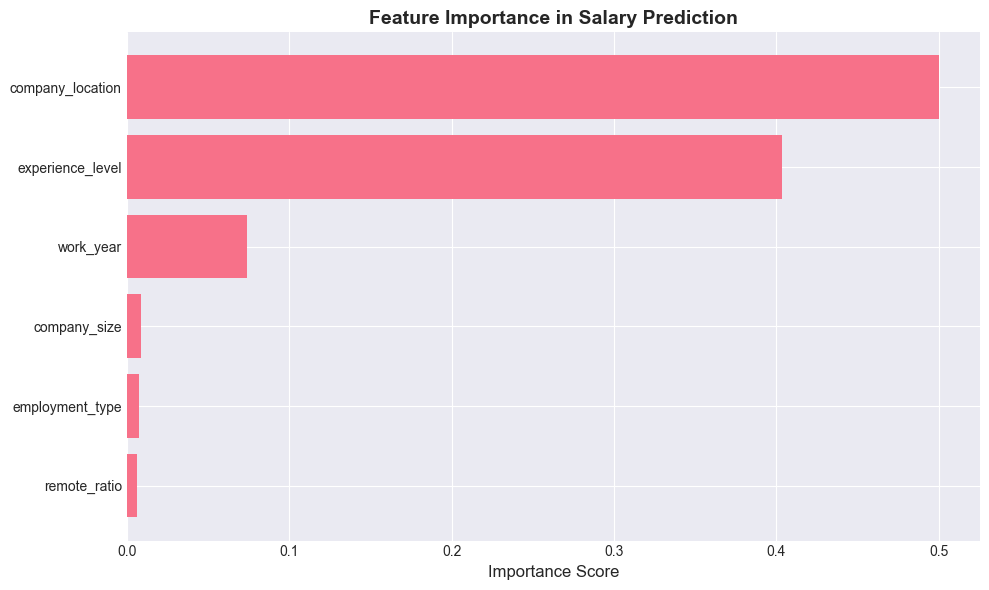

In [97]:
# Step 3.3: Feature Importance Analysis
# Get feature importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nFeature Importance:")
    print(importance_df)
    
    # Visualize
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Importance Score', fontsize=12)
    plt.title('Feature Importance in Salary Prediction', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

In [98]:
# Step 3.4: Make Predictions (Business Scenarios)
# Create prediction scenarios for CEO
scenarios = pd.DataFrame({
    'work_year': [2024, 2024, 2024, 2024],
    'experience_level': ['SE', 'SE', 'MI', 'MI'],
    'employment_type': ['FT', 'FT', 'FT', 'FT'],
    'remote_ratio': [0, 100, 0, 100],
    'company_location': ['US', 'US', 'PL', 'PL'],
    'company_size': ['M', 'M', 'M', 'M']
}, index=['Scenario A', 'Scenario B', 'Scenario C', 'Scenario D'])

# Encode scenarios
scenarios_encoded = scenarios.copy()
for col in ['experience_level', 'employment_type', 'company_location', 'company_size']:
    scenarios_encoded[col] = label_encoders[col].transform(scenarios[col])

# Predict
predictions = best_model.predict(scenarios_encoded)

# Display results
scenarios['Predicted_Salary'] = predictions
scenarios['Predicted_Salary_K'] = (predictions / 1000).round(0)

print("\n" + "="*80)
print("BUSINESS SCENARIO PREDICTIONS")
print("="*80)
print(scenarios[['experience_level', 'remote_ratio', 'company_location', 'Predicted_Salary_K']])

# Calculate savings
print("\n" + "="*80)
print("COST SAVINGS ANALYSIS")
print("="*80)

scenario_a_cost = predictions[0]
scenario_b_cost = predictions[1]
remote_premium = ((scenario_b_cost - scenario_a_cost) / scenario_a_cost) * 100

print(f"Scenario A (Senior, On-site, US): ${scenario_a_cost:,.0f}")
print(f"Scenario B (Senior, Remote, US): ${scenario_b_cost:,.0f}")
print(f"Remote Premium: {remote_premium:+.1f}%")

scenario_c_cost = predictions[2]
scenario_d_cost = predictions[3]
poland_savings = ((scenario_a_cost - scenario_c_cost) / scenario_a_cost) * 100

print(f"\nScenario C (Mid, On-site, Poland): ${scenario_c_cost:,.0f}")
print(f"Savings vs US: {poland_savings:.1f}%")

# Total savings for 20 hires
print(f"\n💰 PROJECTED SAVINGS (for 20 Senior Engineers):")
print(f"US On-site total: ${scenario_a_cost * 20:,.0f}")
print(f"Poland Hybrid total: ${scenario_c_cost * 20:,.0f}")
print(f"TOTAL SAVINGS: ${(scenario_a_cost - scenario_c_cost) * 20:,.0f} per year")


BUSINESS SCENARIO PREDICTIONS
           experience_level  remote_ratio company_location  Predicted_Salary_K
Scenario A               SE             0               US               179.0
Scenario B               SE           100               US               173.0
Scenario C               MI             0               PL                89.0
Scenario D               MI           100               PL                86.0

COST SAVINGS ANALYSIS
Scenario A (Senior, On-site, US): $178,871
Scenario B (Senior, Remote, US): $173,483
Remote Premium: -3.0%

Scenario C (Mid, On-site, Poland): $89,439
Savings vs US: 50.0%

💰 PROJECTED SAVINGS (for 20 Senior Engineers):
US On-site total: $3,577,424
Poland Hybrid total: $1,788,781
TOTAL SAVINGS: $1,788,643 per year


In [99]:
# Phase 4: ADVANCED VISUALIZATION
# Step 4.1: Create "Wow Factor" Visualizations
# 1. Interactive Salary Heatmap by Country and Experience
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "browser"
# pip install plotly and nbformat and import plotly.io as pio...

# Prepare data
top_countries = df_clean['company_location'].value_counts().head(15).index
df_viz = df_clean[df_clean['company_location'].isin(top_countries)]

pivot_country = df_viz.pivot_table(
    values='salary_in_k',
    index='company_location',
    columns='experience_full',
    aggfunc='mean'
).fillna(0)

fig = px.imshow(pivot_country, 
                labels=dict(x="Experience Level", y="Country", color="Salary (K USD)"),
                title="Global Salary Heatmap by Country and Experience Level",
                color_continuous_scale='RdYlGn')
fig.write_html('interactive_heatmap.html')
fig.show()

print("✓ Interactive heatmap saved as 'interactive_heatmap.html'")

✓ Interactive heatmap saved as 'interactive_heatmap.html'


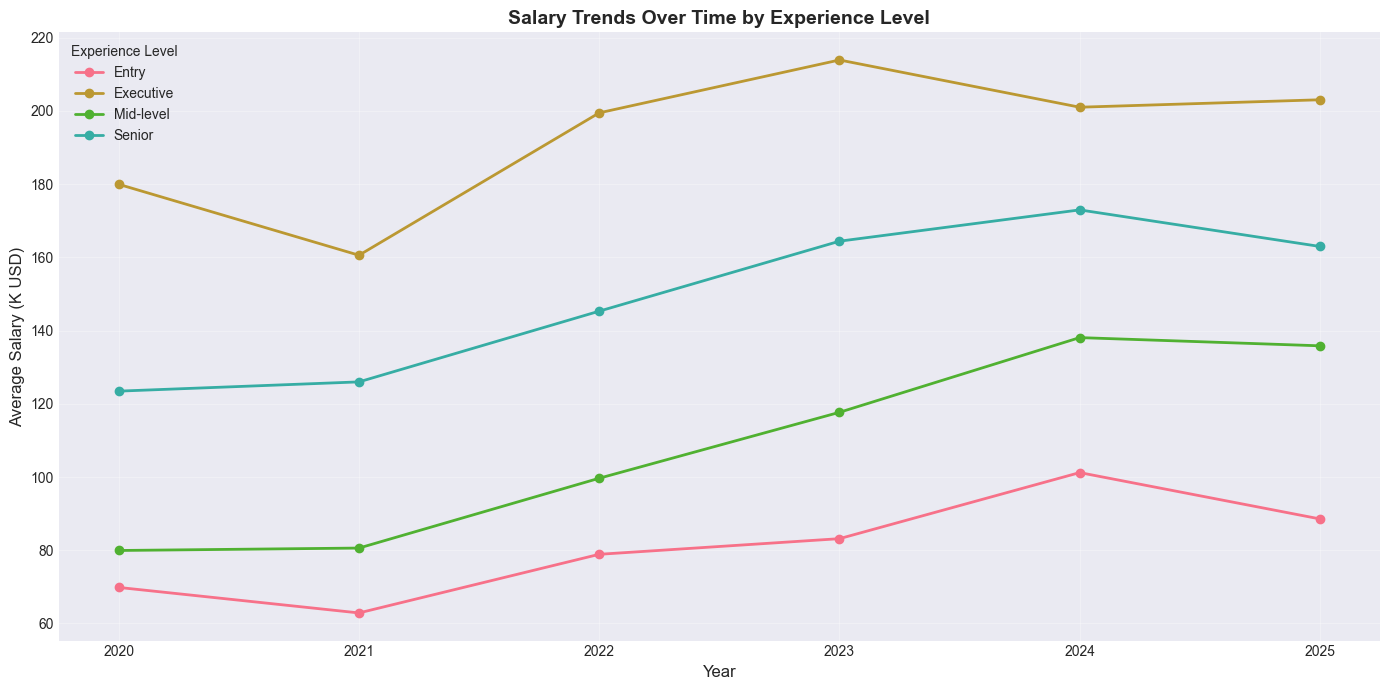

Entry: 5.4% annual growth
Executive: 2.6% annual growth
Mid-level: 14.0% annual growth
Senior: 6.4% annual growth


In [100]:
# Step 4.2: Time Series Analysis (Salary Trends)
# Salary trends over years
yearly_avg = df_clean.groupby(['work_year', 'experience_full'])['salary_in_k'].mean().reset_index()

plt.figure(figsize=(14, 7))
for exp in yearly_avg['experience_full'].unique():
    data = yearly_avg[yearly_avg['experience_full'] == exp]
    plt.plot(data['work_year'], data['salary_in_k'], marker='o', linewidth=2, label=exp)

plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Salary (K USD)', fontsize=12)
plt.title('Salary Trends Over Time by Experience Level', fontsize=14, fontweight='bold')
plt.legend(title='Experience Level', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('salary_trends.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate growth rates
for exp in yearly_avg['experience_full'].unique():
    data = yearly_avg[yearly_avg['experience_full'] == exp].sort_values('work_year')
    if len(data) >= 2:
        first_year_sal = data.iloc[0]['salary_in_k']
        last_year_sal = data.iloc[-1]['salary_in_k']
        growth_rate = ((last_year_sal - first_year_sal) / first_year_sal) * 100
        years = data.iloc[-1]['work_year'] - data.iloc[0]['work_year']
        annual_growth = growth_rate / years if years > 0 else 0
        print(f"{exp}: {annual_growth:.1f}% annual growth")